In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [2]:
from __future__ import print_function
import cv2
import json
import numpy as np
import pandas as pd
from functools import partial
from pathlib import Path 
from tqdm import tqdm
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import keras
from keras.applications import InceptionResNetV2,resnet_v2,nasnet,MobileNetV2
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv1D, Conv2D, BatchNormalization, Activation,Dropout
from keras.layers import MaxPooling2D, AveragePooling2D, Input, Flatten,GlobalAveragePooling2D,SeparableConv2D
from keras.optimizers import Adam , SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import os
import json
from functools import partial
from pathlib import Path 
from tqdm import tqdm
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.models import Model

Using TensorFlow backend.


In [0]:
# Prepare model model saving directory.
model_type='InceptionResnet'
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)


In [4]:
df = pd.read_csv("hvc_annotations.csv")
print(df.head(2))
del df["filename"] # remove unwanted column
df.head(3)

                     filename  gender  ...        bodypose     image_path
0  images/Set1/5580_2 (3).jpg    male  ...  Front-Frontish  resized/1.jpg
1  images/Set1/4650_1 (4).jpg  female  ...  Front-Frontish  resized/2.jpg

[2 rows x 10 columns]


,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg


In [0]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

In [0]:
class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    def __init__(self, df, batch_size=32, shuffle=True, augmentation=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        
        images = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])        
        if self.augmentation is not None:
            images = self.augmentation.flow(images, shuffle=False).next()
        
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        
        return images, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [8]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.5, r_1=0.2, r_2=1/0.2, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
train_df = PersonDataGenerator(
    train_df, 
    batch_size=32, 
    augmentation=ImageDataGenerator(rescale=1./255,rotation_range=100,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True)
    )
)


In [0]:
# create train and validation data generators
train_gen = train_df
valid_gen =  PersonDataGenerator(val_df,batch_size=32,augmentation=ImageDataGenerator(rescale=1./255),shuffle = False)

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 0.04
    if epoch > 50:
        lr *= 0.1
    elif epoch > 40:
        lr *= 0.1
    print('Learning rate: ', lr)
    return lr

In [13]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [14]:
input_shape = (224,224,3)


inputs = Input(shape=input_shape)

num_filters = 64
z = Conv2D(num_filters,
           kernel_size=3,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(inputs)
z = Activation('relu')(z)
z= Conv2D(32,
           kernel_size=3,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(z)
z = Activation('relu')(z)
z = BatchNormalization()(z)

z = MaxPooling2D(pool_size=(2,2),strides=(2,2))(z)

z = Conv2D(64,
           kernel_size=3,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(z)
z = Activation('relu')(z)
z = Conv2D(64,
           kernel_size=3,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(z)
z = Activation('relu')(z)
z = BatchNormalization()(z)

z = MaxPooling2D(pool_size=(2,2),strides=(2,2))(z)

z = SeparableConv2D(128,
           kernel_size=3,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(z)
z = Activation('relu')(z)
z = SeparableConv2D(128,
           kernel_size=3,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(z)
z = Activation('relu')(z)
z = BatchNormalization()(z)

z = MaxPooling2D(pool_size=(2,2),strides=(2,2))(z)

z = SeparableConv2D(256,
           kernel_size=3,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(z)
z = Activation('relu')(z)
z = SeparableConv2D(256,
           kernel_size=3,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(z)
z = Activation('relu')(z)
z = BatchNormalization()(z)

z = Conv2D(16,
           kernel_size=1,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(z)



In [15]:
# Network architecture params.
num_classes = 10
num_filters = 16
num_blocks = 4
num_sub_blocks = 2
use_max_pool = False

# Start model definition.

x = Conv2D(num_filters,
           kernel_size=3,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(z)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Instantiate convolutional base (stack of blocks).
for i in range(num_blocks):
    for j in range(num_sub_blocks-1):
        strides = 1
        #is_first_layer_but_not_first_block = j == 0 and i > 0
        #if is_first_layer_but_not_first_block:
        if (j == 0 and i>0):
            strides = 2
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        #if is_first_layer_but_not_first_block:
        if (j == 0 and i>0):
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)

    num_filters = 2 * num_filters


x = GlobalAveragePooling2D()(x)
neck = x


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck




def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=inputs, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# backbone = keras.applications.inception_resnet_v2.InceptionResNetV2(
    
#     include_top= False, weights=None,
#     input_tensor=Input(shape=(224, 224, 3))
# )

# neck = backbone.output
# neck = Flatten(name="flatten")(neck)
# neck = Dense(512, activation="relu")(neck)


# def build_tower(in_layer):
#     neck = Dropout(0.05)(in_layer)
#     neck = Dense(128, activation="relu")(neck)
#     # neck = Dropout(0.05)(in_layer)
#     # neck = Dense(128, activation="relu")(neck)
#     return neck


# def build_head(name, in_layer):
#     return Dense(
#         num_units[name], activation="softmax", name=f"{name}_output"
#     )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=inputs, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

# model = keras.models.load_model('C:/Users/aadur/saved_models/cifar10_InceptionResnet_model.050.h5')

In [0]:
# freeze backbone
# for layer in backbone.layers:
#     layer.trainable = True

In [18]:
losses = {
	"gender_output": "binary_crossentropy",
	"image_quality_output": "categorical_crossentropy",
	"age_output": "categorical_crossentropy",
	"weight_output": "categorical_crossentropy",
  "bag_output":"categorical_crossentropy",
  "footwear_output":"categorical_crossentropy",
  "pose_output":"categorical_crossentropy",
  "emotion_output":"categorical_crossentropy"
 }
# loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
opt = SGD(lr=0.001, momentum=0.9)
model.compile(
    optimizer=opt,
    loss= losses, 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 32) 18464       activation_1[0][0]               
____________________________________________________________________________________________

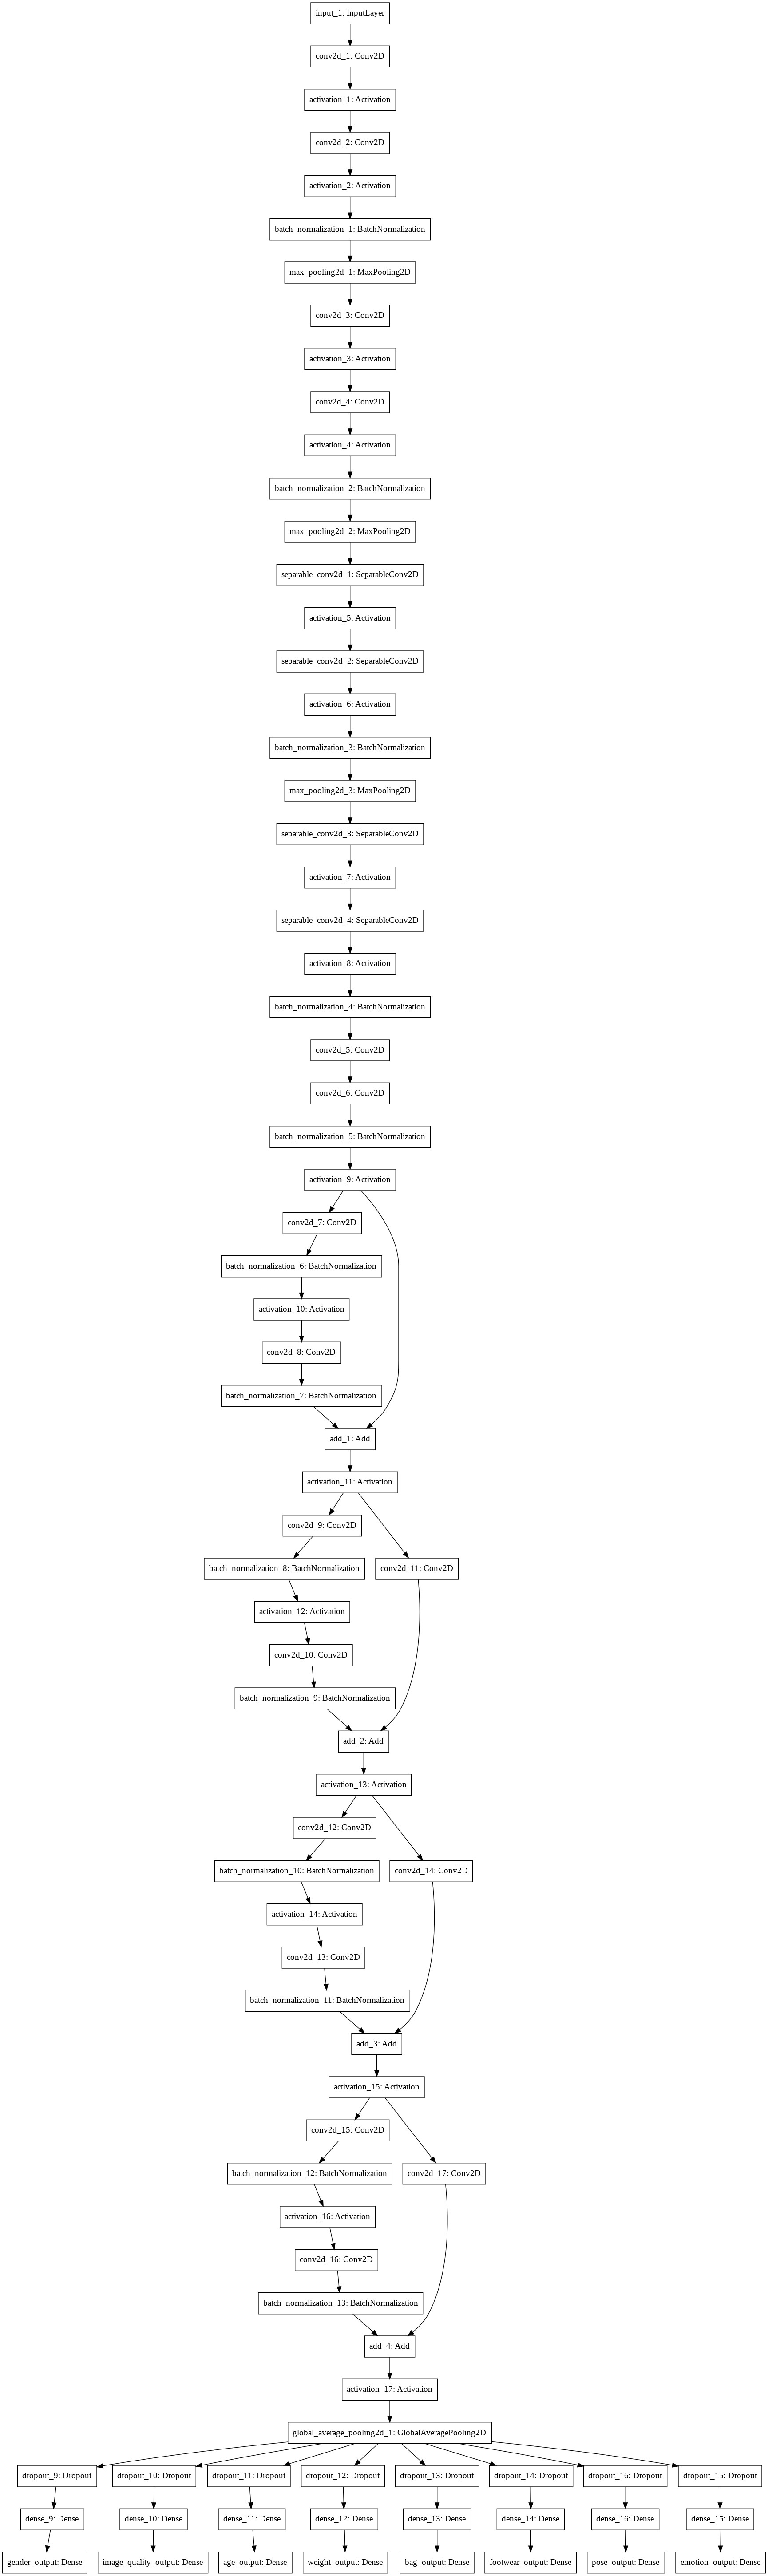

In [20]:
plot_model(model, to_file='model_plot.png', show_layer_names=True)

In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_gender_output_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-4)

callbacks = [checkpoint, lr_scheduler]

In [0]:
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=8, 
    epochs=100,
    verbose=1,
    callbacks=callbacks
)



Epoch 1/100
Learning rate:  0.04
360/360 [==============================] - 177s 491ms/step - loss: 8.1589 - gender_output_loss: 0.6939 - image_quality_output_loss: 0.9889 - age_output_loss: 1.4375 - weight_output_loss: 1.0040 - bag_output_loss: 0.9246 - footwear_output_loss: 1.0367 - pose_output_loss: 0.9379 - emotion_output_loss: 0.9249 - gender_output_acc: 0.5601 - image_quality_output_acc: 0.5505 - age_output_acc: 0.3957 - weight_output_acc: 0.6327 - bag_output_acc: 0.5615 - footwear_output_acc: 0.4608 - pose_output_acc: 0.6133 - emotion_output_acc: 0.7082 - val_loss: 8.0005 - val_gender_output_loss: 0.6901 - val_image_quality_output_loss: 0.9743 - val_age_output_loss: 1.4462 - val_weight_output_loss: 0.9668 - val_bag_output_loss: 0.9266 - val_footwear_output_loss: 0.9774 - val_pose_output_loss: 0.9248 - val_emotion_output_loss: 0.8883 - val_gender_output_acc: 0.5486 - val_image_quality_output_acc: 0.5600 - val_age_output_acc: 0.3889 - val_weight_output_acc: 0.6434 - val_bag_outp

In [0]:
plot_model_history(model_info)